In [1]:
import keras
import matplotlib.pyplot as plt
from IPython.display import clear_output

class PlotLosses(keras.callbacks.Callback):
    def __init__(self, plot_interval=1, evaluate_interval=10, x_val=None, y_val_categorical=None):
        self.plot_interval = plot_interval
        self.evaluate_interval = evaluate_interval
        self.x_val = x_val
        self.y_val_categorical = y_val_categorical
        #self.model = model
    
    def on_train_begin(self, logs={}):
        print('Begin training')
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.logs = []
    
    def on_epoch_end(self, epoch, logs={}):
        if self.evaluate_interval is None:
            self.logs.append(logs)
            self.x.append(self.i)
            self.losses.append(logs.get('loss'))
            self.val_losses.append(logs.get('val_loss'))
            self.acc.append(logs.get('acc'))
            self.val_acc.append(logs.get('val_acc'))
            self.i += 1
        
        if (epoch%self.plot_interval==0):
            clear_output(wait=True)
            f, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(20,5))
            ax1.plot(self.x, self.losses, label="loss")
            ax1.plot(self.x, self.val_losses, label="val_loss")
            ax1.legend()

            ax2.plot(self.x, self.acc, label="acc")
            ax2.plot(self.x, self.val_acc, label="val_acc")
            ax2.legend()
            plt.show();
        #score = self.model.evaluate(x_test, y_test_categorical, verbose=0)
        
        #print("accuracy: ", score[1])
    
    def on_batch_end(self, batch, logs={}):
        if self.evaluate_interval is not None:
            if (batch%self.evaluate_interval==0):
                self.i += 1
                self.logs.append(logs)
                self.x.append(self.i)
                self.losses.append(logs.get('loss'))
                self.acc.append(logs.get('acc'))

                if self.x_val is not None:
                    score = self.model.evaluate(self.x_val, self.y_val_categorical, verbose=0)
                    self.val_losses.append(score[0])
                    self.val_acc.append(score[1])

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import numpy as np
from sklearn.model_selection import train_test_split

# Cargo datos

In [3]:
folder = 'C:/Users/Lenovo/Documents/GitHub/Datasets/Kaggle - Imagenes - MNIST/'
x = np.load(folder+'train_images.npy')
y = np.loadtxt(folder+'train_labels.csv', delimiter=',', skiprows=1)
x_test = np.load(folder+'test_images.npy')

In [10]:
print("x shape:{}".format(x.shape))
print("y shape:{}".format(y.shape))
print("x_test shape:{}".format(x_test.shape))

x shape:(60000, 28, 28)
y shape:(60000,)
x_test shape:(10000, 28, 28)


In [11]:
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size = 0.1)

In [31]:
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint 
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.normalization import BatchNormalization
from keras import optimizers
from keras import initializers

from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization


## Reshape del dataset para usarlo en la CNN (Falta el Depth)

In [32]:
#Rows and columns from images.
img_rows = 28
img_cols = 28
#Reshape del train y valid sets.
x_train = x_train.reshape(x_train.shape[0],img_rows,img_cols,1)
x_valid = x_valid.reshape(x_valid.shape[0],img_rows,img_cols,1)
#Defino el imput_shape
input_shape = (img_rows,img_cols,1)

In [33]:
print("x_train shape:{}".format(x_train.shape))
print("x_valid shape:{}".format(x_valid.shape))

x_train shape:(54000, 28, 28, 1)
x_valid shape:(6000, 28, 28, 1)


In [34]:
y_train_categorical = to_categorical(y_train)
y_val_categorical = to_categorical(y_valid)

# Red neuronal - CNN

In [41]:
output_size = 10
p = 0.25 #Dropout

# Creo el modelo
model=Sequential()

model.add(Convolution2D(filters=6, strides = 1, kernel_size=(3, 3), padding="same", name='Conv1',input_shape=input_shape))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(p))

model.add(Convolution2D(filters=12, strides = 2, kernel_size=(3, 3), padding="same", name='Conv2'))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(p))

#model.add(MaxPooling2D(pool_size=(2, 2), name='MaxPool1'))

model.add(Convolution2D(filters=24, strides = 2, kernel_size=(3, 3), padding="same", name='Conv3'))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(p))

model.add(Flatten())

model.add(Dense(256))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(p))

model.add(Dense(256))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(p))

model.add(Dense(output_size, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1 (Conv2D)               (None, 28, 28, 6)         60        
_________________________________________________________________
activation_8 (Activation)    (None, 28, 28, 6)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 28, 6)         0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 14, 14, 12)        660       
_________________________________________________________________
activation_9 (Activation)    (None, 14, 14, 12)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 12)        0         
_________________________________________________________________
Conv3 (Conv2D)               (None, 7, 7, 24)          2616      
__________

In [42]:
# Compilo el modelo
lr = 0.0001 

ADAM = optimizers.Adam(lr=lr)

model.compile(loss = 'categorical_crossentropy', optimizer=ADAM, metrics=['accuracy'])

In [43]:
# Callbacks

## Callback para graficar
plot_losses = PlotLosses(plot_interval=1, evaluate_interval=60, x_val=x_valid, y_val_categorical=y_val_categorical)
## Callback para guardar pesos
checkpointer = ModelCheckpoint(filepath='cnn.mnist.hdf5', verbose=1, save_best_only=True)

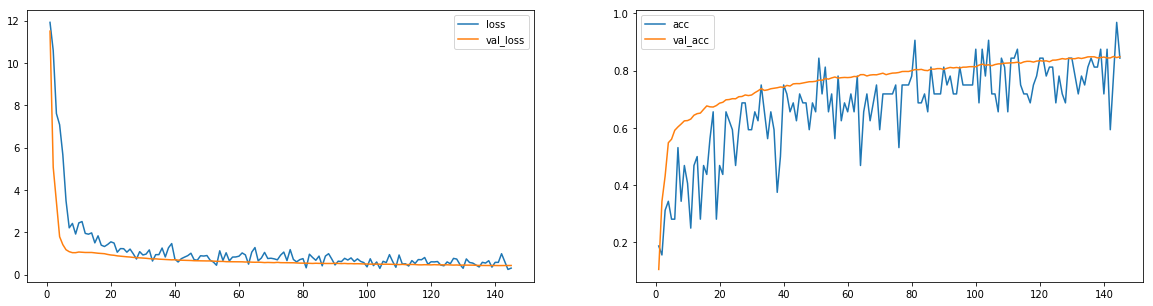


Epoch 00005: val_loss improved from 0.46588 to 0.43795, saving model to cnn.mnist.hdf5
Epoch 6/10
  192/54000 [..............................] - ETA: 8:10 - loss: 0.5543 - acc: 0.7969 

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (1.546513). Check your callbacks.
  % delta_t_median)
C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.773257). Check your callbacks.
  % delta_t_median)


17280/54000 [========>.....................] - ETA: 1:05 - loss: 0.5365 - acc: 0.8009

KeyboardInterrupt: 

In [44]:
batch_size = 1024
epochs = 10

model.fit(x_train
          ,y_train_categorical
          ,epochs=epochs
          ,validation_data = (x_valid, y_val_categorical)
          ,callbacks=[plot_losses, checkpointer],)

In [12]:
loss, acc = model_single_layer.evaluate(x_valid, y_val_categorical)

6000/6000 [==============================] - 2s 310us/step


In [13]:
print(acc)

0.8951666666666667


In [14]:
test_prediction = model_single_layer.predict(x_test)

In [15]:
test_labels = np.argmax(test_prediction, axis = 1)

In [16]:
import pandas
df = pandas.DataFrame(data={"Category": test_labels}).astype(int)
df.to_csv("C:/Users/Lenovo/Documents/GitHub/Lab_ML_ITBA/multiclass/submission_cnn.csv", sep=',',index=True,  index_label='Id')